# Append Method Evaluation

This notebook evaluates the Append query expansion method (BM25 and TF-IDF) on TREC-COVID and Climate-Fever datasets, comparing against baseline.

## How to Run

1. Press "Run All" to execute all cells
2. All required DUMMY files will be created automatically if missing
3. Results will be saved to `output/eval/metric/append/`
4. Plots will be saved to `output/eval/plot/append/`


In [1]:
# Setup: imports and path configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add src to path
current = Path.cwd()
if current.name == 'eval' and current.parent.name == 'runner':
    project_root = current.parent.parent
else:
    project_root = current
sys.path.insert(0, str(project_root / 'src'))

from eval import (
    compute_metrics_from_files,
    save_metrics_to_csv,
    load_run_file,
    load_qrels_file,
    compute_per_query_metric,
    compare_runs
)
from eval.utils import (
    ensure_directory,
    create_dummy_run_file,
    create_dummy_qrels_file,
    find_top_delta_queries,
    create_summary_table
)

print("Setup complete!")


Setup complete!


## Ensure DUMMY Files Exist


In [2]:
# Define paths
datasets = ['trec_covid', 'climate_fever']
retrieval_methods = ['bm25', 'tf_idf']
method_name = 'append'
output_base = project_root / 'output'

# Create directory structure
ensure_directory(output_base / 'retrieval' / method_name)
ensure_directory(output_base / 'eval' / 'metric' / method_name)

# Create dummy append run files if missing
for dataset in datasets:
    for retrieval in retrieval_methods:
        run_path = output_base / 'retrieval' / method_name / f'run_{retrieval}_{dataset}_DUMMY.csv'
        if not run_path.exists():
            create_dummy_run_file(str(run_path), num_queries=10, num_docs_per_query=100)
            print(f"Created dummy run: {run_path}")

print("DUMMY files check complete!")


Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\append\run_bm25_trec_covid_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\append\run_tf_idf_trec_covid_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\append\run_bm25_climate_fever_DUMMY.csv
Created dummy run: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\retrieval\append\run_tf_idf_climate_fever_DUMMY.csv
DUMMY files check complete!


## Compute Metrics for All 4 Combos


In [3]:
# Compute metrics for append method
all_metrics = {}

for dataset in datasets:
    qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
    
    for retrieval in retrieval_methods:
        # Append run
        append_run_path = output_base / 'retrieval' / method_name / f'run_{retrieval}_{dataset}_DUMMY.csv'
        append_metric_path = output_base / 'eval' / 'metric' / method_name / f'metric_{retrieval}_{dataset}_DUMMY.csv'
        
        # Baseline run for comparison
        baseline_run_path = output_base / 'retrieval' / 'baseline' / f'run_{retrieval}_{dataset}_DUMMY.csv'
        
        # Compute metrics
        metrics = compute_metrics_from_files(str(append_run_path), str(qrels_path), k=10)
        save_metrics_to_csv(
            metrics,
            str(append_metric_path),
            dataset=dataset,
            method=method_name,
            retrieval=retrieval
        )
        
        all_metrics[(dataset, method_name, retrieval)] = metrics
        print(f"{retrieval} × {dataset}: nDCG@10={metrics['ndcg@10']:.4f}, MAP={metrics['map']:.4f}")

print("\nMetrics computation complete!")


bm25 × trec_covid: nDCG@10=1.0000, MAP=1.0000
tf_idf × trec_covid: nDCG@10=1.0000, MAP=1.0000
bm25 × climate_fever: nDCG@10=1.0000, MAP=1.0000
tf_idf × climate_fever: nDCG@10=1.0000, MAP=1.0000

Metrics computation complete!


## Compare with Baseline (Statistical Tests)


In [4]:
# Compare append method with baseline
comparison_results = []

for dataset in datasets:
    qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
    
    for retrieval in retrieval_methods:
        append_run_path = output_base / 'retrieval' / method_name / f'run_{retrieval}_{dataset}_DUMMY.csv'
        baseline_run_path = output_base / 'retrieval' / 'baseline' / f'run_{retrieval}_{dataset}_DUMMY.csv'
        
        # Statistical comparison
        stats = compare_runs(
            str(baseline_run_path),
            str(append_run_path),
            str(qrels_path),
            metric='ndcg@10',
            k=10
        )
        
        comparison_results.append({
            'dataset': dataset,
            'retrieval': retrieval,
            'baseline_mean': stats['baseline_mean'],
            'append_mean': stats['system_mean'],
            'difference': stats['mean_difference'],
            'p_value': stats['p_value'],
            'ci_lower': stats['ci_lower'],
            'ci_upper': stats['ci_upper']
        })
        
        print(f"{retrieval} × {dataset}: Δ={stats['mean_difference']:.4f}, p={stats['p_value']:.4f}")

comparison_df = pd.DataFrame(comparison_results)
print("\nComparison Summary:")
print(comparison_df.to_string(index=False))


bm25 × trec_covid: Δ=0.0000, p=nan
tf_idf × trec_covid: Δ=0.0000, p=nan
bm25 × climate_fever: Δ=0.0000, p=nan
tf_idf × climate_fever: Δ=0.0000, p=nan

Comparison Summary:
      dataset retrieval  baseline_mean  append_mean  difference  p_value  ci_lower  ci_upper
   trec_covid      bm25            1.0          1.0         0.0      NaN       0.0       0.0
   trec_covid    tf_idf            1.0          1.0         0.0      NaN       0.0       0.0
climate_fever      bm25            1.0          1.0         0.0      NaN       0.0       0.0
climate_fever    tf_idf            1.0          1.0         0.0      NaN       0.0       0.0


## Summary Table and Top Delta Queries


In [5]:
# Create summary table
summary_df = create_summary_table(all_metrics)
summary_path = output_base / 'eval' / 'metric' / method_name / f'summary_DUMMY.csv'
summary_df.to_csv(summary_path, index=False)

print("Summary Metrics Table:")
print(summary_df.to_string(index=False))

# Show top delta queries for one example
dataset_example = datasets[0]
retrieval_example = retrieval_methods[0]

qrels = load_qrels_file(str(output_base / 'ingest' / dataset_example / 'qrels.csv'))
baseline_run = load_run_file(str(output_base / 'retrieval' / 'baseline' / f'run_{retrieval_example}_{dataset_example}_DUMMY.csv'))
append_run = load_run_file(str(output_base / 'retrieval' / method_name / f'run_{retrieval_example}_{dataset_example}_DUMMY.csv'))

baseline_scores = compute_per_query_metric(baseline_run, qrels, metric='ndcg@10', k=10)
append_scores = compute_per_query_metric(append_run, qrels, metric='ndcg@10', k=10)

top_positive, top_negative = find_top_delta_queries(baseline_scores, append_scores, top_n=10)

print(f"\nTop 10 Positive Δ (nDCG@10) - {retrieval_example} × {dataset_example}:")
for qid, delta in top_positive[:5]:
    print(f"  {qid}: +{delta:.4f}")

print(f"\nTop 10 Negative Δ (nDCG@10) - {retrieval_example} × {dataset_example}:")
for qid, delta in top_negative[:5]:
    print(f"  {qid}: {delta:.4f}")


Summary Metrics Table:
      dataset method retrieval  ndcg@10  map  recall@100  mrr
   trec_covid append      bm25      1.0  1.0         1.0  1.0
   trec_covid append    tf_idf      1.0  1.0         1.0  1.0
climate_fever append      bm25      1.0  1.0         1.0  1.0
climate_fever append    tf_idf      1.0  1.0         1.0  1.0

Top 10 Positive Δ (nDCG@10) - bm25 × trec_covid:
  q009: +0.0000
  q002: +0.0000
  q001: +0.0000
  q010: +0.0000
  q008: +0.0000

Top 10 Negative Δ (nDCG@10) - bm25 × trec_covid:
  q009: 0.0000
  q002: 0.0000
  q001: 0.0000
  q010: 0.0000
  q008: 0.0000


## Plot nDCG@10 Comparison


Plot saved to: c:\Users\Lenovo\CodeProjects\VSC\domain-specific-query-expansion-with-llms\output\eval\plot\plot_append_ndcg_DUMMY.png


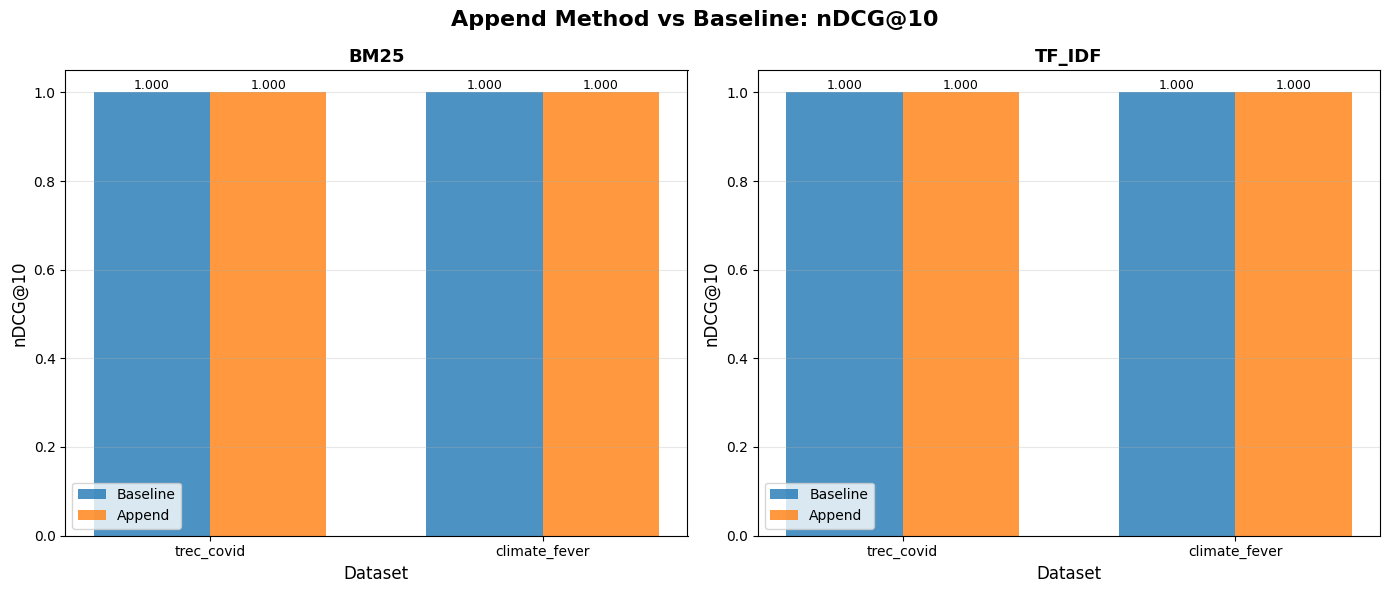

In [6]:
# Load baseline metrics for comparison
from eval.compute_metrics import compute_metrics_from_files as load_metrics

baseline_metrics = {}
for dataset in datasets:
    for retrieval in retrieval_methods:
        qrels_path = output_base / 'ingest' / dataset / 'qrels.csv'
        baseline_run_path = output_base / 'retrieval' / 'baseline' / f'run_{retrieval}_{dataset}_DUMMY.csv'
        baseline_metrics[(dataset, retrieval)] = load_metrics(str(baseline_run_path), str(qrels_path), k=10)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Append Method vs Baseline: nDCG@10', fontsize=16, fontweight='bold')

for idx, retrieval in enumerate(retrieval_methods):
    ax = axes[idx]
    x = np.arange(len(datasets))
    width = 0.35
    
    baseline_scores = [baseline_metrics[(d, retrieval)]['ndcg@10'] for d in datasets]
    append_scores = [all_metrics[(d, method_name, retrieval)]['ndcg@10'] for d in datasets]
    
    bars1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.8)
    bars2 = ax.bar(x + width/2, append_scores, width, label='Append', alpha=0.8)
    
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('nDCG@10', fontsize=12)
    ax.set_title(f'{retrieval.upper()}', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plot_path = output_base / 'eval' / 'plot' / f'plot_{method_name}_ndcg_DUMMY.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Plot saved to: {plot_path}")
plt.show()
